Starting simulation at t=0. s for a duration of 0.6 s
0.6 s (100%) simulated in 3s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 4s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 3s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


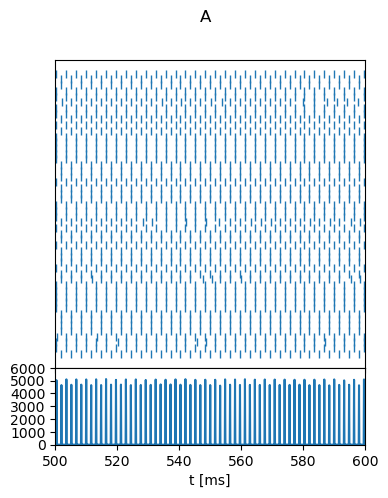

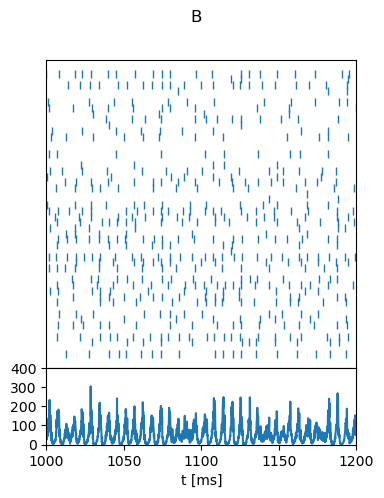

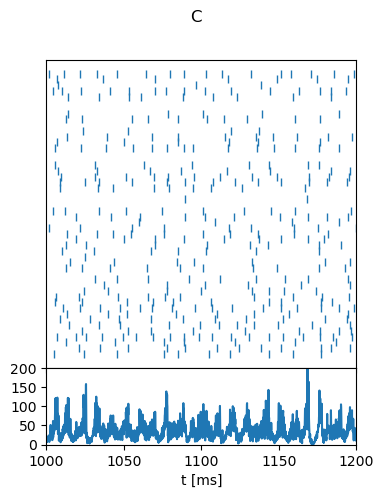

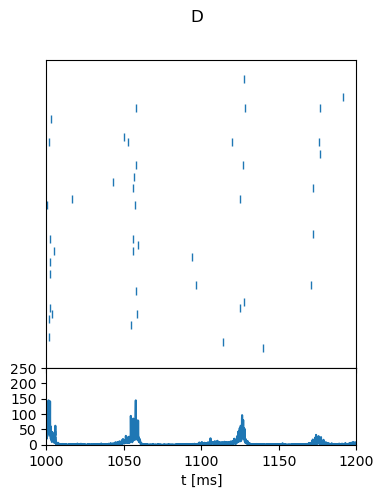

In [ ]:
import random
from brian2 import *
import matplotlib.pyplot as plt

# code source: https://brian2.readthedocs.io/en/stable/examples/frompapers.Brunel_2000.html

def sim(g, nu_ext_over_nu_thr, sim_time, ax_spikes, ax_rates, rate_tick_step):
    """
    g -- relative inhibitory to excitatory synaptic strength
    nu_ext_over_nu_thr -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    ax_spikes -- matplotlib axes to plot spikes on
    ax_rates -- matplotlib axes to plot rates on
    rate_tick_step -- step size for rate axis ticks
    """

    # network parameters
    N_E = 10000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 20 * ms
    theta = 20 * mV
    V_r = 10 * mV
    tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV
    D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    neurons = NeuronGroup(N,
                          """
                          dv/dt = -v/tau : volt (unless refractory)
                          """,
                          threshold="v > theta",
                          reset="v = V_r",
                          refractory=tau_rp,
                          method="exact",
    )

    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    exc_synapses = Synapses(excitatory_neurons, target=neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)

    inhib_synapses = Synapses(inhibitory_neurons, target=neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)

    nu_ext = nu_ext_over_nu_thr * nu_thr

    external_poisson_input = PoissonInput(
        target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J
    )

    rate_monitor = PopulationRateMonitor(neurons)

    # record from the first 50 excitatory neurons
    spike_monitor = SpikeMonitor(neurons[:50])

    run(sim_time, report='text')

    ax_spikes.plot(spike_monitor.t / ms, spike_monitor.i, "|")
    ax_rates.plot(rate_monitor.t / ms, rate_monitor.rate / Hz)

    ax_spikes.set_yticks([])

    ax_spikes.set_xlim(*params["t_range"])
    ax_rates.set_xlim(*params["t_range"])

    ax_rates.set_ylim(*params["rate_range"])
    ax_rates.set_xlabel("t [ms]")

    ax_rates.set_yticks(
        np.arange(
            params["rate_range"][0], params["rate_range"][1] + rate_tick_step, rate_tick_step
        )
    )

    plt.subplots_adjust(hspace=0)


parameters = {
    "A": {
        "g": 3,
        "nu_ext_over_nu_thr": 2,
        "t_range": [500, 600],
        "rate_range": [0, 6000],
        "rate_tick_step": 1000,
    },
    "B": {
        "g": 6,
        "nu_ext_over_nu_thr": 4,
        "t_range": [1000, 1200],
        "rate_range": [0, 400],
        "rate_tick_step": 100,
    },
    "C": {
        "g": 5,
        "nu_ext_over_nu_thr": 2,
        "t_range": [1000, 1200],
        "rate_range": [0, 200],
        "rate_tick_step": 50,
    },
    "D": {
        "g": 4.5,
        "nu_ext_over_nu_thr": 0.9,
        "t_range": [1000, 1200],
        "rate_range": [0, 250],
        "rate_tick_step": 50,
    },
}

for panel, params in parameters.items():

    fig = plt.figure(figsize=(4, 5))
    fig.suptitle(panel)

    gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[4, 1])

    ax_spikes, ax_rates = gs.subplots(sharex="col")

    sim(
        params["g"],
        params["nu_ext_over_nu_thr"],
        params["t_range"][1] * ms,
        ax_spikes,
        ax_rates,
        params["rate_tick_step"],
    )

plt.show()